# Florence-2
microsoft/Florence-2-large

In [1]:

from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont
import torch
import warnings
import supervision as sv

warnings.filterwarnings("ignore")

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float32  # float16 가능하면 float16 권장
print("------------------ 0. Setup Check ------------------")
print("Using device:", device)
print("Using torch_dtype:", torch_dtype)

print("---------------------- 1. 모델 로드 ----------------------")
model_id = "microsoft/Florence-2-large"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype=torch_dtype
).eval().to(device)

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


------------------ 0. Setup Check ------------------
Using device: cuda:0
Using torch_dtype: torch.float32
---------------------- 1. 모델 로드 ----------------------


In [2]:
def run_florence(image_path, task_prompt="<OCR_WITH_REGION>", text_input=None):
    """
    Florence-2 OCR 실행 후 Supervision Detections 객체 반환
    task_prompt 중 "<OCR_WITH_REGION>"로 테스크 설정 : https://huggingface.co/microsoft/Florence-2-large
    """
    image = Image.open(image_path).convert("RGB")

    prompt = task_prompt if text_input is None else task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

    generated_ids = model.generate(
            input_ids=inputs["input_ids"].cuda(),
            pixel_values=inputs["pixel_values"].cuda(),
            max_new_tokens=4096,
            num_beams=3,
            do_sample=False,
            early_stopping=True
        )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(
            generated_text,
            task=task_prompt,
            image_size=(image.width, image.height)
        )
    # Supervision Detections 변환
    detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, parsed_answer, resolution_wh=image.size)
    
    return image, detections, parsed_answer

def visualize_detections(image, detections):
    """
    시각화 함수
    """
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    font_size = 14
    font = ImageFont.truetype(font_path, font_size)
    
    bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
    annotated_image = bounding_box_annotator.annotate(scene=image.copy(), detections=detections)

    # 텍스트 그리기 (annotated_image 위에)
    draw = ImageDraw.Draw(annotated_image)
    

    for i, box_points in enumerate(detections.data['xyxyxyxy']):
        x_coords = box_points[:, 0]
        y_coords = box_points[:, 1]
        x_min, y_min = x_coords.min(), y_coords.min()

        label = detections.data['class_name'][i]
        draw.text((x_min, y_min - font_size), label, font=font, fill="black")
        
    for idx,text in enumerate(detections.data['class_name']) :
        print(f'{idx+1} : {text}')
    
    return annotated_image

# TEST


===== ./data/easy_task_test05_v1.PNG =====
1 : </s>NO.1 SINTER MAIN 한국관 3F
2 : LOCAL AREA
3 : HBI-750-A-101
4 : NO.I SINTERN PLC
5 : S-TIC1034-A1
6 : T1-C103A
7 : R/O PANEL
8 : WASTE EP-C INLET DUCT TEMP TRANSMITTER
9 : (A2PT GROUP)
10 : INST.
11 : BOX
12 : S-PTIC1033-AII
13 : PT-C1034
14 : 0.6/KV F-OWSB 2C 1.550
15 : WASTER EP- C INLET DUCT PRESS TRANSMITTER-A
16 : S-PCTIC1038-AI
17 : PT-CT1038
18 : 0.0/KW F-CWSB 2c 1.590
19 : WASSE EP-c INLET DOCT PRESS TRANSmitter-B
20 : S-TPIC1035-AI
21 : PT-CI103A
22 : 0.8/Kv F-OWS8 2C1.550
23 : WASTEC EP-O INLET DDUCT PRESS TRANSITMER-C
24 : INST.
25 : BOX
26 : S- PTIC1030-AI
27 : PT-CP1030
28 : 0.06/KY F-OMSB 2 C 1.559
29 : WASTC EP-0 OUTLET DUTT PRESS TRANSWITTER
30 : S-TC1038A1
31 : TT-C108B
32 : 0.5/K/V F~OWSB 20c 1,550
33 : WASTe EP--C OUTLET DUPT TEMP TRANSITTER (ASC SUPPLY)


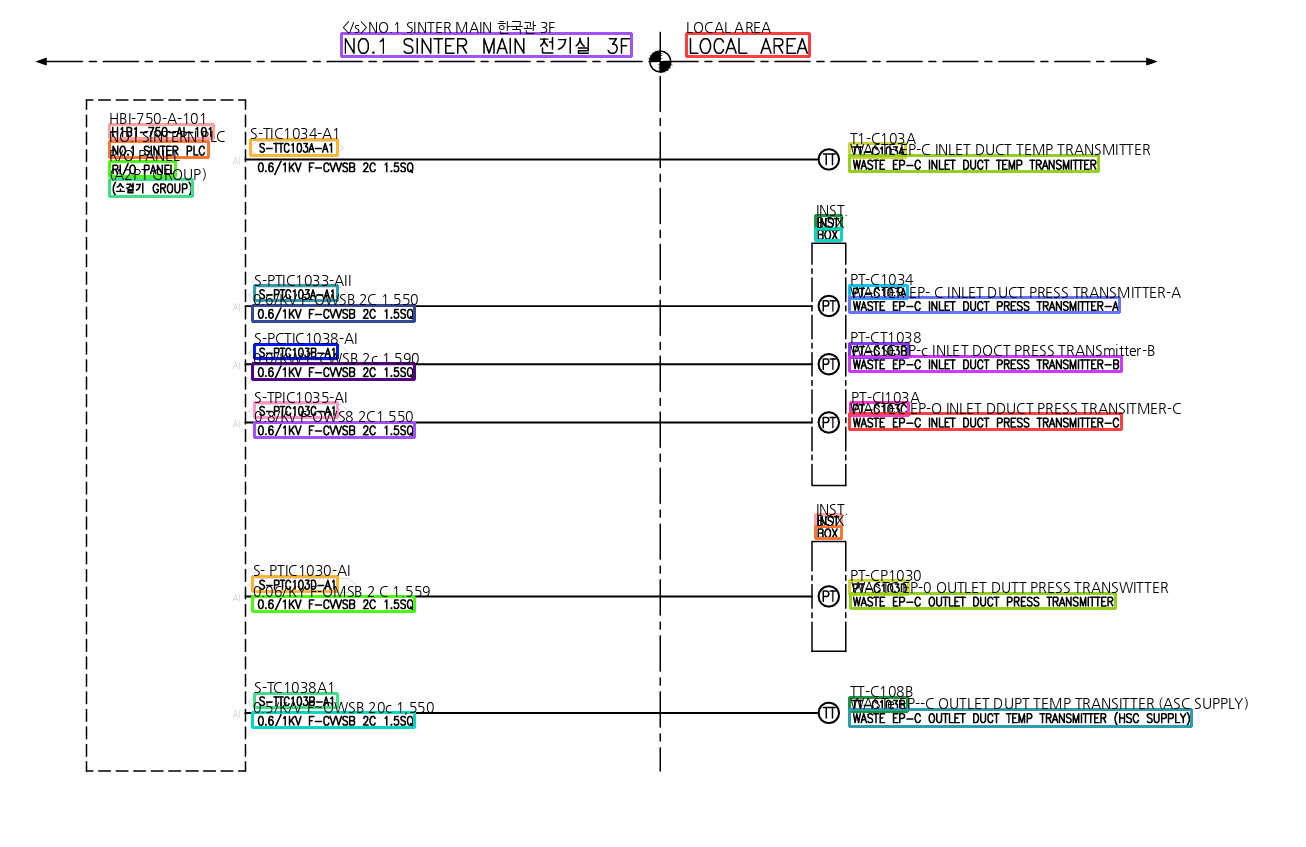

In [3]:
test_images = [
    "./data/easy_task_test05_v1.PNG",
    # "./data/test05.JPG",
]

for img_path in test_images:
    image, detections, parsed_answer = run_florence(img_path)
    print(f"\n===== {img_path} =====")
    # print(parsed_answer)
    
    annotated_img = visualize_detections(image, detections)
    annotated_img.show()  # 또는 .save("output.jpg") 로 저장 가능